In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

# Лабораторная работа 3

## Алгоритм периодической прогонки

### Постановка задачи

Рассмотрим уравнение:

$$ y'' - P^2(x) y = f(x) $$,

где $P^2(x) > 0$ и $f(x)$ - заданные периодические функции с периодом 1.

Для его решения используется разностная схема:

$
\begin{align}
    \begin{cases}
        \frac{y_1 - 2 y_0 + y_{N-1}}{h^2} - P^2(0) y_0 = f(0), \\
        \frac{y_{n+1} - 2 y_n + y_{n-1}}{h^2} - P^2(n h) y_n = f(n h), \space n = 1, 2, \dots, N-2, \\
        \frac{y_0 - 2 y_{N-1} + y_{N-2}}{h^2} - P^2(1 - h) y_{N-1} = f(1 - h), \\
    \end{cases}
\end{align}
$

где $N h = 1$.

Параметры системы:

- $h = 0.005$
- $P^2(x) = 10 + \sin{(2 \pi x)}$
- $f(x) = \cos{(2 \pi x)}$

## Описание алгоритма

Рассмотрим уравнение:

$$y'' + p(x) y' + q(x) y = f(x) $$

с условиями периодичности

$$ y^{(p)}(0) = y^{(p)}(1), \space p \in \{0, 1\}. $$

Дискретный аналог уравнения:

$$ \frac{y_{n+1} - 2 y_n + y_{n-1}}{h^2} + p_n \frac{y_{n+1} - y_{n-1}}{2h} + q_n y_n = f_n. $$


В силу периодичности дискретное уравнение должно выполняться во всех точках сетки, включая граничные.

Кроме того, в силу граничного условия при $p = 0, \space y_0 = y_{N+1}$. 

Система сеточных уравнений примет вид:

$$
\begin{align}
    \begin{cases}
        a_0 y_N - b_0 y_0 + c_0 y_1 = \varphi_0, \\
        \dots \\
        a_n y_{n-1} - b_n y_n + c_n y_{n+1} = \varphi_n, \\
        \dots \\
        a_N y_{N-1} - b_N y_N + c_N y_0 = \varphi_N, \\
    \end{cases}
\end{align}
$$

где $a_k = 1 - 0.5 p_k h$, $b_k = 2 - q_k h^2$, $c_k = 1 + 0.5 p_k h$, $\varphi_k = f_k h^2$.

Обобщение стандартных прогоночных соотношений (для трехточечной прогонки) на периодический случай:

$$ y_{n-1} = \alpha_n y_n + \beta_n + \gamma_n y_N. $$


Отсюда: $\alpha_1 = c_0 / b_0$, $\beta_1 = - \varphi_0 / b_0$, $\gamma_1 = a_0/b_0.$

Тогда зависимость для прогоночных коэффициентов: $\alpha_{k+1} = \frac{c_k}{b_k - \alpha_k a_k}$, $\beta_{k+1} = \frac{a_k \beta_k - \varphi_k}{b_k - \alpha_k a_k}$, $\gamma_{k+1} = \frac{a_k \gamma_k}{b_k - \alpha_k a_k}$.

В итоге получим:

$$ a_N (\alpha_N y_N + \beta_N + \gamma_N y_n) - b_N y_N + c_N y_0 = \varphi_N. $$

Сгруппировав члены, перепишем выражение следующим образом:

$$ y_N = \mu_N y_0 + \nu_N, $$

где:

$$ \mu_N = \frac{-c_N}{a_N (\alpha_N + \gamma_N) - b_N}, \space \nu_N = \frac{\varphi_N - a_N \beta_N}{a_N (\alpha_N + \gamma_N) - b_N}. $$

Получаем связь $y_{n+1}$ с $y_0$:

$$ y_{n-1} = \alpha_n (\mu_n y_0 + \nu_n) + \beta_n + \gamma_n (\mu_N y_0 + \nu_N). $$

Отсюда получаем рекуррентные соотношения:

$$ \mu_{n-1} = \alpha_n \mu_n + \gamma_n \mu_N, \space \nu_{n-1} = \beta_n + \alpha_n \nu_n + \gamma_n \nu_N. $$

Эти коэффициенты вычисляются в обратном порядке - справа налево - аналог обратного хода прогонки. Последнее соотношение приводит к явному выражению для $y_0$:

$$ y_0 = \frac{\nu_0}{1 - \mu_0}. $$

In [11]:
# Initialization
p = lambda x : 0
q = lambda x : -10 - np.sin(2 * np.pi * x)
f = lambda x : np.cos(2 * np.pi * x)

x_1 = 0
x_2 = 1

def periodic_tridiagonal(p, q, f, x_1, x_2, N):
    a = lambda h, p_n : 1 - 0.5 * (h * p_n)
    b = lambda h, q_n : 2 - q_n * h**2
    c = lambda h, p_n : 1 + 0.5 * (h * p_n)
    phi = lambda h, f_n : f_n * h**2

    x = np.linspace(x_1, x_2, num = N + 1, endpoint = True)
    h = (x_2 - x_1) / N

    alpha = np.zeros(N)
    beta = np.zeros(N)
    gamma = np.zeros(N)

    b_0 = b(h, q(x[0]))
    alpha[0] = c(h, p(x[0])) / b_0
    beta[0] = -phi(h, f(x[0])) / b_0
    gamma[0] = a(h, p(x[0])) / b_0

    for i in range(1, N):
        a_i = a(h, p(x[i-1]))
        denominator = b(h, q(x[i-1])) - a_i * alpha[i-1]

        alpha[i] = c(h, p(x[i-1])) / denominator
        beta[i] = (a_i * beta[i-1] - phi(h, f(x[i-1]))) / denominator
        gamma[i] = a_i * gamma[i-1] / denominator

    nu = np.zeros(N)
    mu = np.zeros(N)
    
    a_N_min_1 = a(h, p(x[N-1]))
    denominator = a_N_min_1 * (alpha[N-1] + gamma[N-1]) - b(h, q(x[N - 1]))

    mu[N-1] = -c(h, p(x[N-1])) / denominator
    nu[N-1] = (phi(h, f(x[N - 1])) - a_N_min_1 * beta[N-1]) / denominator

    for i in range(N - 2, -1, -1):
        nu[i] = beta[i] + alpha[i] * nu[i+1] + gamma[i] * nu[N-1]
        mu[i] = alpha[i] * mu[i+1] + gamma[i] * mu[N-1]

    y = np.zeros(N + 1)

    y[0] = nu[0] / (1 - mu[0])
    for i in range(1, N):
        y[i] = nu[i] + mu[i] * y[0]
    y[N] = y[0]

    return x, y

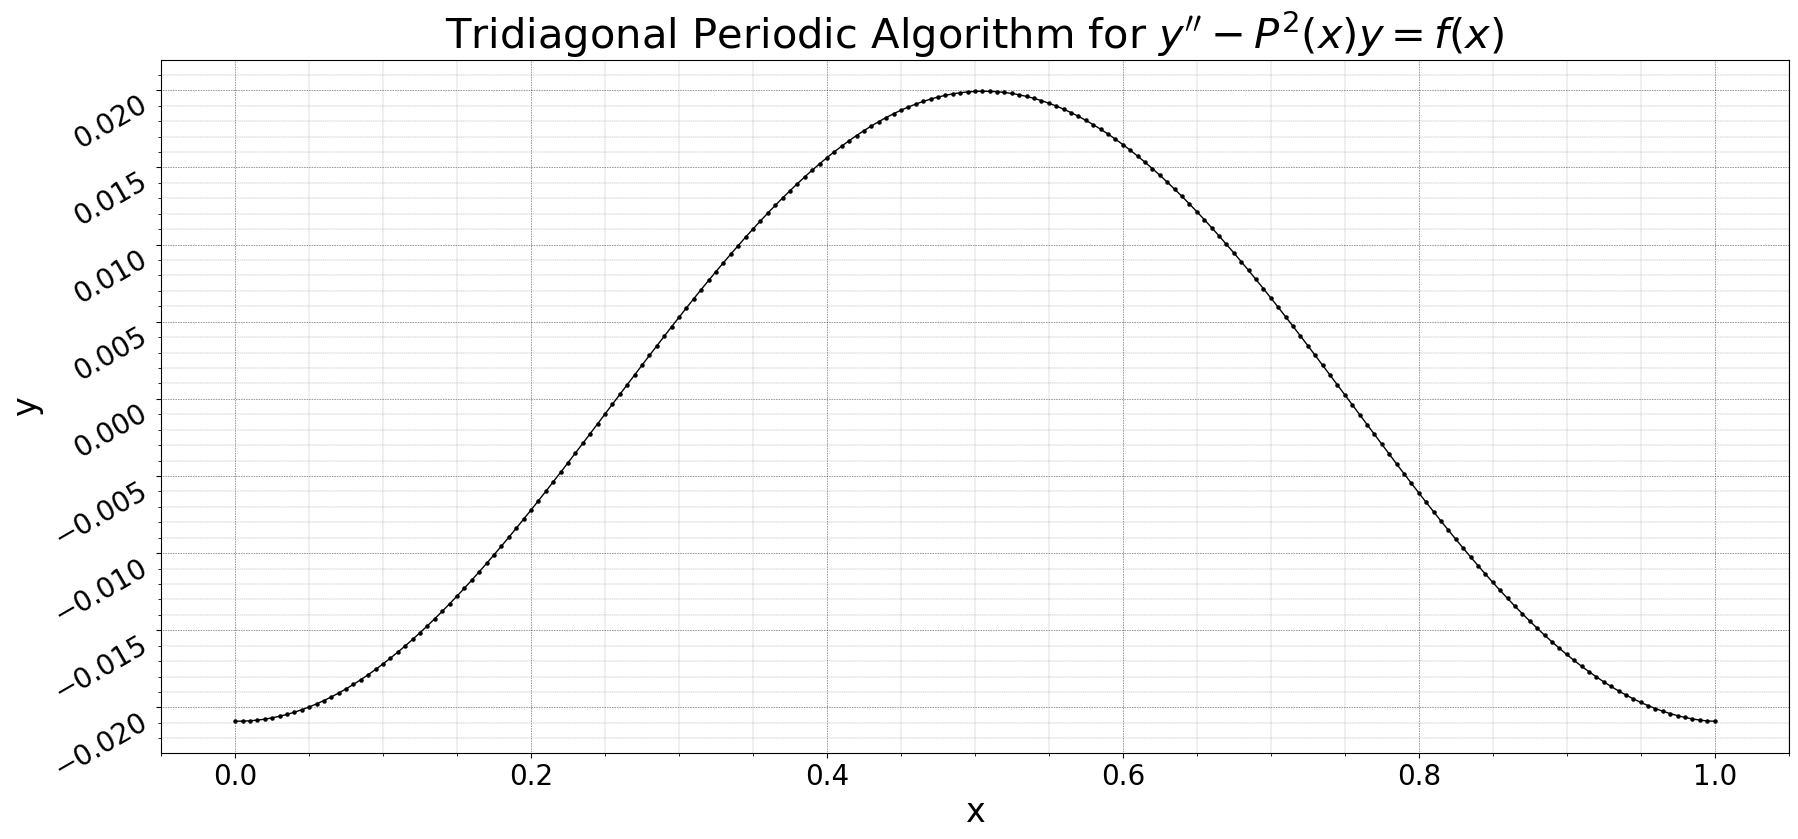

In [12]:
N = 200 # h = 0.005
x, y = periodic_tridiagonal(p, q, f, x_1, x_2, N)

plt.figure(figsize = (21, 9), dpi = 100)
plt.title(r"Tridiagonal Periodic Algorithm for $y'' - P^2(x) y = f(x)$", fontsize = 30)

plt.xlabel("x", fontsize = 24)
plt.xticks(fontsize =  20, ha = "center", va = "top")

plt.ylabel("y", fontsize = 24)
plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.scatter(x, y, s = 5, color = "black")
plt.plot(x, y, linewidth = 1, color = "black")

plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
plt.minorticks_on()
plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

plt.show()